# Проектная практика. Осень 2024.
Исследование эффективности различных методов оптимизации при обучении
PINN.

Уравнение теплопроводности: \\

$$ \frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2},\ x \in (0, L),\ t > 0 $$ \\

Начальные условия: \\

$$ \begin{cases}
u(x, 0) = f(x), & x \in [0,L], \\
u(0, t) = u(L, t) = 0, & t > 0.
\end{cases}
 $$

Задача: Реализовать PINN метод решения начально-краевой задачи для уравнения теплопроводности. Сравнить эффективность различных оптимизаторов
(SGD, Adam, RMSprop, L-BFGS).

# Реализация обучения

In [ ]:
import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all logs, 1 = filter out INFO, 2 = filter out WARNING, 3 = filter out ERROR
tf.get_logger().setLevel('ERROR')

Задаём данные

In [ ]:
L = 1.0
alpha = 0.1

num_samples = 128  # плотность сетки

# t > 0 - пределы для t
start = 0.0
end = 1.0

In [ ]:
import math

# начальная функция
def f(x):
  return tf.sin(tf.constant(math.pi) * x)

Составляем сетку. Выбираем случайные точки.

In [ ]:
import numpy as np


# генерация датасета с нужными точками
def generate_data(count_points, x_val="random", t_val="random"):
  if x_val == "random" and t_val == "random":
    count = count_points ** 2
    repeat = count_points
  else:
    count = count_points
    repeat = 1

  if x_val == "random":
    x = np.linspace(0, L, count_points)
  else:
    x = np.ones(shape=(count, 1)) * x_val
  x = np.repeat(x, repeat)
  x = x.reshape(count, 1)

  if t_val == "random":
    t = np.linspace(start, end, count_points)
  else:
    t = np.ones(shape=(count, 1)) * t_val
  t = np.tile(t, repeat)
  t = t.reshape(count, 1)

  x = tf.convert_to_tensor(x, dtype=tf.float32)
  t = tf.convert_to_tensor(t, dtype=tf.float32)
  return x, t

In [ ]:
physic_dataset = generate_data(count_points=num_samples)
initial_dataset = generate_data(count_points=num_samples**2, t_val=0)

x1, t1 = generate_data(count_points=num_samples**2, x_val=0)
x2, t2 = generate_data(count_points=num_samples**2, x_val=L)

x = tf.concat((x1, x2), axis=0)
t = tf.concat((t1, t2), axis=0)
boundary_dataset = x, t

Составляем лосс

$$ \mathcal{L}_{\text{physics}} = \frac{1}{N_{\text{physics}}} \sum_{i=1}^{N_{\text{physics}}} \left( \frac{\partial u}{\partial t} - \alpha \frac{\partial^2 u}{\partial x^2} \right)^2 $$ \\
$$ \mathcal{L}_{\text{initial}} = \frac{1}{N_{\text{initial}}} \sum_{i=1}^{N_{\text{initial}}} \left( u(x_i, 0) - f(x_i) \right)^2 $$ \\
$$ \mathcal{L}_{\text{boundary}} = \frac{1}{N_{\text{boundary}}} \sum_{i=1}^{N_{\text{boundary}}} \left( u(0, t_i) \right)^2 + \frac{1}{N_{\text{boundary}}} \sum_{i=1}^{N_{\text{boundary}}} \left( u(L, t_i) \right)^2 $$ \\

In [ ]:
def initial_loss(model, x, t):
  data = tf.concat((x, t), axis=1)
  u_pred = model(data)
  loss = tf.reduce_mean(tf.square(u_pred - f(x)))
  return loss


def boundary_loss(model, x, t):
  data = tf.concat((x, t), axis=1)
  u_pred = model(data)
  loss = tf.reduce_mean(tf.square(u_pred))
  return loss


def physic_loss(model, x, t):
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    tape.watch(t)

    data = tf.concat((x, t), axis=1)
    u_pred = model(data)

    u_t = tape.gradient(u_pred, t)

    u_x = tape.gradient(u_pred, x)
    u_xx = tape.gradient(u_x, x)

  loss = u_t - (alpha * u_xx)
  return tf.reduce_mean(tf.square(loss))

In [ ]:
# шаг обучения
def step(model, physic, initial, boundary, optimizer):
  with tf.GradientTape() as tape:
    p_loss = physic_loss(model, physic[0], physic[1])

    b_loss = boundary_loss(model, boundary[0], boundary[1])

    i_loss = initial_loss(model, initial[0], initial[1])

    total_loss = p_loss + b_loss + i_loss

  gradients = tape.gradient(total_loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  return p_loss, b_loss, i_loss

# процесс обучения
def train(model, physic, initial, boundary, optimizer, epochs):
  history = np.zeros(shape=(epochs, 3))

  best_vars = model.trainable_variables
  best_loss = float('inf')

  for i in range(1, epochs + 1):

    p_loss, b_loss, i_loss = step(model, physic, initial, boundary, optimizer)
    history[i - 1, 0] = p_loss
    history[i - 1, 1] = b_loss
    history[i - 1, 2] = i_loss

    total_loss = (p_loss + b_loss + i_loss).numpy()

    if total_loss < best_loss:
      best_loss = total_loss
      best_vars = model.trainable_variables

    if i % 50 == 0:
      print(f"Epoch {i}/{epochs}. Total loss: {total_loss:.6f}, Physic loss: {p_loss:.6f}, Boundary loss: {b_loss:.6f}, Initial loss: {i_loss:.6f}")

  return history, best_vars, best_loss

Строим модель и выбираем оптимизатор

In [ ]:
from tensorflow.keras.layers import Input, Dense


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
epochs = 6000

model = tf.keras.Sequential([ # создание модели
    Input(shape=(2, )),
    Dense(64, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(1)
])

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                     │ (None, 64)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,417 (17.25 KB)

 Trainable params: 4,417 (17.25 KB)

 Non-trainable params: 0 (0.00 B)

Обучение

In [ ]:
import time


curr = time.time() # засекаем время

history, best_vars, best_loss = train(model, physic_dataset, initial_dataset, boundary_dataset, optimizer, epochs)

print()
print(f"Model was training for {round(time.time() - curr)} seconds!")
print(f"The min loss is {best_loss:.6f}")

Epoch 50/6000. Total loss: 0.274973, Physic loss: 0.016975, Boundary loss: 0.074492, Initial loss: 0.183506
Epoch 100/6000. Total loss: 0.272083, Physic loss: 0.017249, Boundary loss: 0.080644, Initial loss: 0.174190
Epoch 150/6000. Total loss: 0.268029, Physic loss: 0.017316, Boundary loss: 0.079901, Initial loss: 0.170813
Epoch 200/6000. Total loss: 0.258706, Physic loss: 0.018052, Boundary loss: 0.076310, Initial loss: 0.164344
Epoch 250/6000. Total loss: 0.217790, Physic loss: 0.017075, Boundary loss: 0.062517, Initial loss: 0.138199
Epoch 300/6000. Total loss: 0.119638, Physic loss: 0.017306, Boundary loss: 0.029883, Initial loss: 0.072449
Epoch 350/6000. Total loss: 0.054981, Physic loss: 0.016304, Boundary loss: 0.011354, Initial loss: 0.027324
Epoch 400/6000. Total loss: 0.036607, Physic loss: 0.013183, Boundary loss: 0.007315, Initial loss: 0.016109
Epoch 450/6000. Total loss: 0.018817, Physic loss: 0.006654, Boundary loss: 0.003591, Initial loss: 0.008572
Epoch 500/6000. Tota

График loss

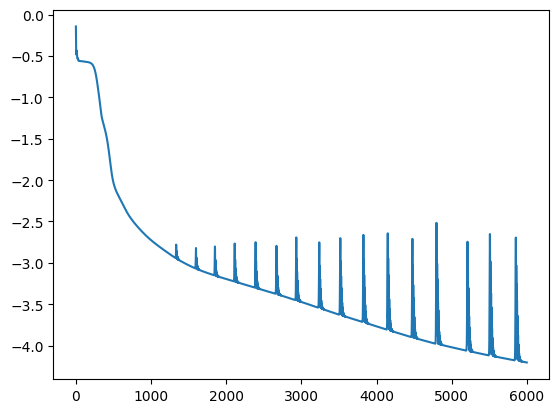

In [ ]:
import matplotlib.pyplot as plt


epochs_arr = np.arange(0, epochs)
start_epoch = 0 # с какой эпохи смотреть график

plt.plot(epochs_arr[start_epoch:], np.log10(np.sum(history[start_epoch:], axis=1)))
plt.show()

Выбираем лучшую модель

In [ ]:
model.set_weights(best_vars)

Тестирование

In [ ]:
# создаём новые точки

num_samples = 10000

x = np.random.uniform(0.0, L, size=(num_samples, 1))
t = np.random.uniform(start, end, size=(num_samples, 1))

x_test = tf.convert_to_tensor(x, dtype=tf.float32)
t_test = tf.convert_to_tensor(t, dtype=tf.float32)

Графики

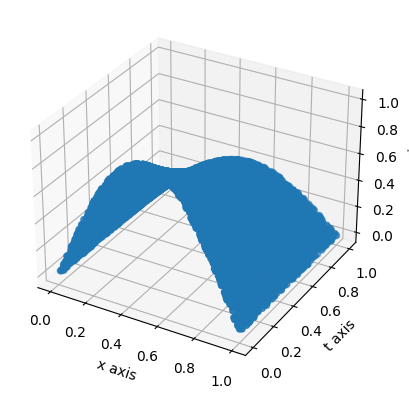

In [ ]:
u_pred = model(tf.concat([x, t], axis=1)).numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, t, u_pred)

ax.set_xlabel('x axis')
ax.set_ylabel('t axis')
ax.set_zlabel('u axis')

plt.show()

**Правильное решение**

$$ u(x, t) = \sin(\pi x)e^{-\alpha \pi^2 t} $$

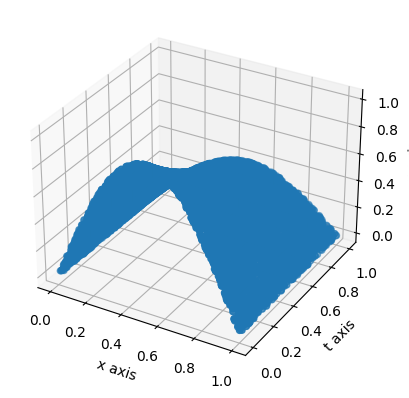

In [ ]:
u = np.sin(np.pi * x) * np.exp((-alpha * (np.pi ** 2)) * t)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, t, u)

ax.set_xlabel('x axis')
ax.set_ylabel('t axis')
ax.set_zlabel('u axis')

plt.show()

Подсчёт MAE (сравниваем с правильным решением)

In [ ]:
print(f"MAE: {np.mean(np.abs(u - u_pred))}")

MAE: 0.0007730602819766478
